<a href="https://colab.research.google.com/github/oytungunes/PythonCodeExamples/blob/main/GridMask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math
import tensorflow as tf

def transform(image, inv_mat, image_shape):

      h, w, c = image_shape
      cx, cy = w//2, h//2

      new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
      new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
      new_zs = tf.ones([h*w], dtype=tf.int32)

      old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
      old_coords_x, old_coords_y = tf.round(old_coords[0, :] + w//2), tf.round(old_coords[1, :] + h//2)

      clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
      clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
      clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)

      old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
      old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
      new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
      new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))

      old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
      new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
      rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
      rotated_image_channel = list()
      for i in range(c):
          vals = rotated_image_values[:,i]
          sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
          rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))

      return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

def random_rotate(image, angle, image_shape):

    def get_rotation_mat_inv(angle):
          #transform to radian
          angle = math.pi * angle / 180

          cos_val = tf.math.cos(angle)
          sin_val = tf.math.sin(angle)
          one = tf.constant([1], tf.float32)
          zero = tf.constant([0], tf.float32)

          rot_mat_inv = tf.concat([cos_val, sin_val, zero,
                                     -sin_val, cos_val, zero,
                                     zero, zero, one], axis=0)
          rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])

          return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform(image, rot_mat_inv, image_shape)

In [ ]:
import numpy as np
import tensorflow as tf

def GridMask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):

    h, w = image_height, image_width
    hh = int(np.ceil(np.sqrt(h*h+w*w)))
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges <0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges <0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

    return mask

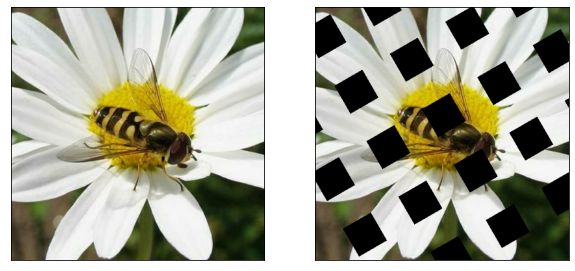

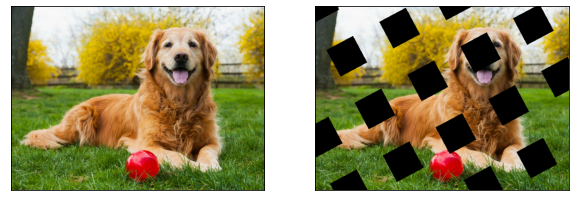

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt

def apply_grid_mask(image, image_shape, d1, d2, rotate_angle, ratio):
    mask = GridMask(image_shape[0], image_shape[1], d1, d2, rotate_angle, ratio)
    if image_shape[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)

    return image * tf.cast(mask, tf.uint8)


def show_before_after(image, image_masked):
    plt.figure(figsize=(10,6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(image_masked)
    plt.xticks([])
    plt.yticks([])
    plt.show()

#if __name__ == '__main__':
daisy_bits = tf.io.read_file('/content/drive/MyDrive/imgs/daisy.png')
dog_bits = tf.io.read_file('/content/drive/MyDrive/imgs/dog.png')

daisy = tf.image.decode_png(daisy_bits)
dog = tf.image.decode_png(dog_bits)

daisy_masked = apply_grid_mask(daisy, daisy.get_shape().as_list(), 90, 150, 23, 0.5)
dog_masked = apply_grid_mask(dog, dog.get_shape().as_list(), 90, 150, 23, 0.5)

show_before_after(daisy, daisy_masked)
show_before_after(dog, dog_masked)